# Fine-tuning notebook

Here we will demonstrate fine tuning on a dataset consisting of flood events in the UK and Ireland, as used in the granite-geospatial-uki-flood-detection model, with the addition of events from Spain. For this particular example, we curated flood imagery from the [south east of Spain](https://emergency.copernicus.eu/mapping/list-of-components/EMSR388), where flooding was seen across a broad area in late September 2019. We fine-tune on a dataset that combines this Spanish flood with floods from the UK and Ireland.

Labelled flood events in the form of flood extents have been retrieved from the [Copernicus Emergency Management service (CEMS)](https://emergency.copernicus.eu/) Portal and provided as a fine tuning dataset. To fine tune for a different region, you can follow the instructions below to find and prepare additional local training data.

#### Preparation of additional/alternative fine-tuning data
- find a flood event of your choice on CEMS and download the zip files containing the relevant data. The flood outlines are available in vector format, so convert these to raster.
- note the imagery dates from the CEMS website for the event. [Query Sentinel-1 and Sentinel-2 imagery](https://sentinelhub-py.readthedocs.io/en/latest/) from sentinel hub over the flood event region, within a 2 to 3 days window from the imagery date listed on the CEMS website.
- process the data as described in the [model card](../granite-geospatial-flood-detection-uki-model-card.md).

#### Technical requirements
It’s best to run this notebook on a machine with one or more GPUs. If this is not possible, you can reduce the amount of training data to shorten the training time, at a cost of reduced performance. You can also try reducing the batch size.



### 0.1 set-up for running on Google Colab

You may want to take this opportunity to double check you're using GPUs on Google Colab before proceeding any further. We have tested this notebook using T4 GPU on the free colab account. 

#### 0.1.1 check python version
It's recommended that you run this notebook using python 3.12. Let's check the python version by executing the cell below.

In [1]:
!python --version

Python 3.12.11


#### 0.1.2 setting up your environment
To install the necessary packages, execute the cell below. This will take a few minutes. Once the installation process is done, a window will pop up to ask you to restart the session. This is normal and you should proceed to restart using the interface in the pop up window. Once the session has restarted, it's important that you ignore the cell below, and go straight to section 0.1.3.

In [2]:
import sys

# if running on colab
if "google.colab" in sys.modules:
    # Clone the ibm-granite GitHub repo
    !git clone https://github.com/ibm-granite/geospatial.git
    # Install the package
    %pip install -e ./geospatial/uki-flooddetection[colab]

#### 0.1.3 Set up working directory
This is the first thing you should run after restarting your Colab session.

In [3]:
import sys

# Only run this cell if running on Colab.
if "google.colab" in sys.modules:
    # Change to the notebooks directory
    %cd geospatial/uki-flooddetection/notebooks
    %pwd

Now your environment is set up for Google Colab. Please proceed to section 0.3.

### 0.2 set-up for running on your local machine

Before running through this notebook it's best to create a virtual environment and install the necessary packages there before running this notebook. The instructions can be found in [README.md](../README.md).

  Once that's done, come back to this notebook and make sure it's using the newly made virtual environment.

  Please proceed to section 0.3.

### 0.3 importing packages and setting up paths

In [4]:
# Imports
import os
import re
from pathlib import Path

import rioxarray
from granite_geo_flood.utils.helper import (
    clip_image,
    download_data,
    overwrite_checkpoint_in_config,
    plot_images_pred_valencia,
    prep_valencia_images,
)
from huggingface_hub import hf_hub_download

In [5]:
# some basic set-up
%matplotlib inline

project_root = Path("../")
hf_repo_name = "ibm-granite/granite-geospatial-uki"

  ## 1. Fine-tuning 

  We'll go through the fine-tunining process now. If you encounter any problems, you can skip this section and download the fine-tuned weights to carry out inference in section 2.2.

  ### 1.1 Data prep
  Let's place this in `../data/regions`

In [6]:
# specify where the training data are stored
data_path = project_root / "data" / "regions"
os.makedirs(data_path, exist_ok=True)

In [ ]:
# Download and uncompress full-tile dataset
save_file = (
    project_root
    / "data"
    / "granite-geospatial-uki-flooddetection-dataset-combined-uki-spain.tar.gz"
)
download_data("uki_and_spain", save_file)
command = f'tar -xf "{save_file}" --directory "{data_path}"'
os.system(command)

  ### 1.2 Model prep - checkpoints



  We can get the pre-trained weights from HuggingFace. 

In [8]:
# checkpoint-specific
checkpoint_name = "granite_geospatial_uki.pt"
checkpoint_folder = project_root / "data" / "checkpoints"

inference_checkpoint = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=checkpoint_name,
        local_dir=checkpoint_folder,
    )
)

  ### 1.3 Model prep - configs



  As this model uses additional bands to the prithvi model included in terratorch, we allow for the weights for these additional bands to be read in by terratorch by defining a custom module in `./custom_modules/granite_geospatial_uki.py`.



  We make sure to point to this as a backbone in our config file.

In [ ]:
# download model config
config_name = "config.yaml"
config_folder = project_root / "configs"

config_file = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=config_name,
        local_dir=config_folder,
    )
)

# rename the config file so that it doesn't get overwritten if using both notebooks
config_file = config_file.replace(
    config_folder / "config_granite_geospatial_uki_flood_detection_v2.yaml"
)

Please note: the `batch_size` parameter is set to 4 and `max_epochs` has been set to 5 to avoid running out of memory or runtime for users of the free tier colab compute resources. This is enough to demonstrate the entire workflow to the user, but may not result in the best performance. It'll be best to find additional compute resources and increase `batch_size` and `max_epochs` in the downloaded config file for improved performance. For reference, the `granite_geospatial_uki_flood_detection_v2.ckpt` checkpoint in section 2.2 was obtained by fine-tuning on a `batch_size` of 16 and using early stopping. 

  ### 1.4 Carry out fine-tuning

  Execute the below cell to print out a command. Check the command and the config location to make sure that the config file exists in the expected folder. 

As touched upon before, **granite-geospatial-uki** is not a standard model in Terratorch. To load the model (or any custom backbone) we can put the model file in a folder called `custom_modules`. In this example the file is called `granite_geospatial_uki.py`. 

 If you're planning to run this command outside of this notebook when applying it to your own project, it's important to **make sure you're running terratorch from the directory where the `custom_modules` folder is located**.  

In [10]:
fine_tuning_command = f"terratorch fit --config ./{config_file}"
print(fine_tuning_command)

terratorch fit --config ./../configs/config_granite_geospatial_uki_flood_detection_v2.yaml


If everything looks ok, we'll execute the below cell to fine-tune the model. 

In [ ]:
os.system(fine_tuning_command)

  ## 2. Checking the results - inference prep



  Let's gather and specify the relevant files for carrying out inference in a new folder. 
  Look for your .ckpt file produced during the fine-tuning process and list it in the cell in section 2.1. 
  If you didn't fine-tune the model or you only fine-tuned ir for a small number of epochs, you can still carry out inference by downloading the fine-tuned weights from Hugging Face. Skip section 2.1 and execute section 2.2 if you'd like to do that. 

#### 2.1 inference checkpoint specification if you fine-tuned yourself

Only execute the cell below if you're happy that you've ran the fine-tuning for long enough that you've got a checkpoint from the "best" epoch. 

If you've used the default epoch number listed in the Hugging Face config (e.g. when running fine-tuning using the free tier colab compute resources) it's best to skip the cell below. If you head to section 2.2 instead, you can download the fully trained weights and carry out inference on it. 

In [13]:
# find the checkpoint produced from the fine-tuning process, and overwrite below
inference_checkpoint = (
    project_root
    / "data"
    / "fine_tuning"
    / "granite_geospatial_uki_flood_detection_v2"
    / "lightning_logs"
    / "version_0"
    / "checkpoints"
    / "epoch=4.ckpt"
)

#### 2.2 inference checkpoint download if you didn't fine-tune yourself or you fine-tuned only for a few epochs 

In [ ]:
checkpoint_name = "granite_geospatial_uki_flood_detection_v2.ckpt"
checkpoint_folder = project_root / "data" / "checkpoints"

inference_checkpoint = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=checkpoint_name,
        local_dir=checkpoint_folder,
    )
)

In [15]:
overwrite_checkpoint_in_config(config_file, inference_checkpoint)

In [16]:
pretrain_checkpoint_name = "granite_geospatial_uki.pt"

pretrain_checkpoint = Path(
    hf_hub_download(
        repo_id=hf_repo_name,
        filename=pretrain_checkpoint_name,
        local_dir=checkpoint_folder,
    )
)

#### 2.3 preparing paths and inference data

In [17]:
# specify where you want to save your inference results
inference_dir = project_root / "data" / "inference" / "valencia"

# specify where the test images are stored
data_dir = project_root / "data" / "regions" / "valencia"

In [ ]:
# Download the inference data
save_file = (
    project_root
    / "data"
    / "granite-geospatial-uki-flooddetection-dataset-valencia.tar.gz"
)
download_data("valencia", save_file)
command = f'tar -xf "{str(save_file)}" --directory "{str(data_path)}"'
os.system(command)

If you're running this notebook using the free tier colab compute resources, please execute the cell below. This cell will clip the images on which we plan to run inference to a smaller size, to avoid running out of memory. Please note, this will overwrite the downloaded images. If you're running this notebook on other compute you can likely skip the cell below. 

In [ ]:
file_before_flood = "../data/regions/valencia/valencia_2024-09-30.tif"
image_before_flood = rioxarray.open_rasterio(file_before_flood)
image_before_flood = clip_image(image_before_flood)

file_after_flood = "../data/regions/valencia/valencia_2024-10-31.tif"
image_after_flood = rioxarray.open_rasterio(file_after_flood)
image_after_flood = clip_image(image_after_flood)

# write out clipped data
image_before_flood.rio.write_crs("epsg:4326", inplace=True)
image_before_flood = image_before_flood.squeeze()
image_before_flood.rio.to_raster(file_before_flood)
image_after_flood.rio.write_crs("epsg:4326", inplace=True)
image_after_flood = image_after_flood.squeeze()
image_after_flood.rio.to_raster(file_after_flood)

 Let's carry out inference on the test images. Execute the cell below to print out a command. Make sure the paths look correct. 

In [19]:
# run inference
inference_command = f"terratorch predict -c ./{config_file} --ckpt_path ./{inference_checkpoint} --predict_output_dir ./{inference_dir} --data.init_args.predict_data_root ./{data_dir}"
print(inference_command)

terratorch predict -c ./../configs/config_granite_geospatial_uki_flood_detection_v2.yaml --ckpt_path ./../data/checkpoints/granite_geospatial_uki_flood_detection_v2.ckpt --predict_output_dir ./../data/inference/valencia --data.init_args.predict_data_root ./../data/regions/valencia


If everything looks good, execute the cell below. 

In [ ]:
os.system(inference_command)

  ## 3. Checking the results - visualisation



In [21]:
# indices of RGB bands, in order, in the input images of size (h x w x bands)
rgb_bands = [
    4,
    3,
    2,
]

# index of VV band, in the input images of size (h x w x bands)
vv_band = 0

save_dir = project_root / "plots" / "valencia"
os.makedirs(save_dir, exist_ok=True)

# defining where to save the image
save_file = save_dir / "inference.png"

# find the relevant data
image_file_before_flood = data_dir / "valencia_2024-09-30.tif"
image_before_flood = rioxarray.open_rasterio(image_file_before_flood)

image_file_after_flood = data_dir / "valencia_2024-10-31.tif"
image_after_flood = rioxarray.open_rasterio(image_file_after_flood)

pred_file_before_flood = inference_dir / "valencia_2024-09-30_pred.tif"
pred_before_flood = rioxarray.open_rasterio(pred_file_before_flood)

pred_file_after_flood = inference_dir / "valencia_2024-10-31_pred.tif"
pred_after_flood = rioxarray.open_rasterio(pred_file_after_flood)

In [22]:
# prep valencia data for plotting
s1_before_flood, s2_before_flood, pred_before_flood = prep_valencia_images(
    image_before_flood, pred_before_flood, rgb_bands, vv_band
)
s1_after_flood, s2_after_flood, pred_after_flood = prep_valencia_images(
    image_after_flood, pred_after_flood, rgb_bands, vv_band
)

In [23]:
# find dates of floods
pattern = ".*_(\\d{4}-\\d{2}-\\d{2}).*"
flood_date_before = re.findall(pattern, str(image_file_before_flood))[0]
flood_date_after = re.findall(pattern, str(image_file_after_flood))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.03713].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00015133173..2.7784503].


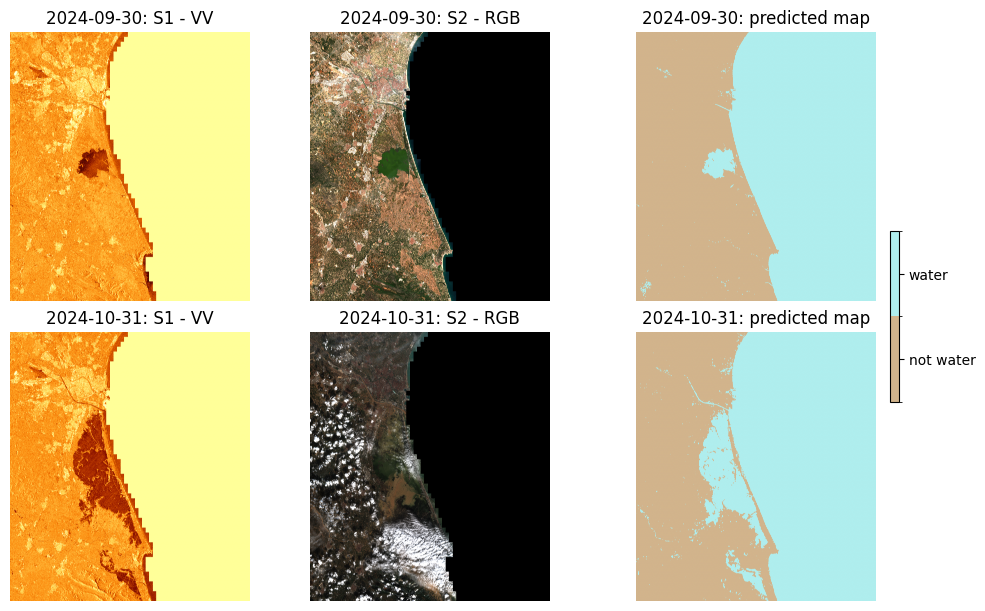

In [24]:
plot_images_pred_valencia(
    s1_before_flood,
    s2_before_flood,
    pred_before_flood,
    s1_after_flood,
    s2_after_flood,
    flood_date_before,
    flood_date_after,
    pred_after_flood,
    save_file,
)

Here we see the inputs and output of the flood detection model fine tuned for Spain and used to delineate flooded areas in Valencia using data from both Sentinel 1 and Sentinel 2 on 30 September (before the flood), and on 31 October 2024. The Sentinel-2 image is partly obscured by clouds, especially to the south. Here, the model relies on Sentinel-1 to delineate the flooded area.

## Next steps

Check out the other granite-geospatial models for [Above Ground Biomass](https://huggingface.co/ibm-granite/granite-geospatial-biomass), [Canopy Height](https://huggingface.co/ibm-granite/granite-geospatial-canopyheight), [Land Surface Temperature](https://huggingface.co/ibm-granite/granite-geospatial-land-surface-temperature) and [Weather and Climate Downscaling](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling). 